In [12]:
from scipy.io import wavfile
import tables
import numpy

#read data from wav
fs, data = wavfile.read('./recorder_output/records/audio.wav')

#ouput
folder='./recorder_output/'
filename= 'audio.h5'
#save_to acoular h5 format
acoularh5 = tables.open_file(folder+filename, mode = "w", title = filename)
acoularh5.create_earray('/','time_data', atom=None, title='', filters=None, \
                         expectedrows=100000, chunkshape=[256,64], \
                         byteorder=None, createparents=False, obj=data)
acoularh5.set_node_attr('/time_data','sample_freq', fs)
acoularh5.close()

[('audio_cache.h5', 3)]
[('audio_cache.h5', 4)]


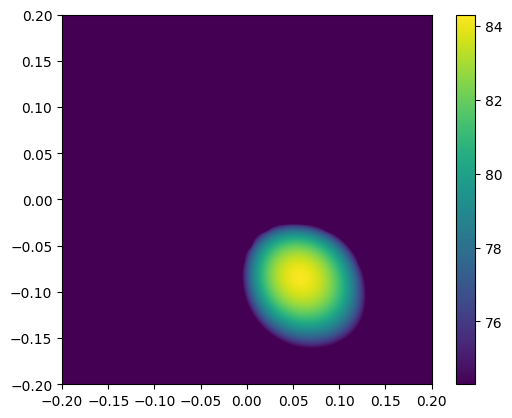

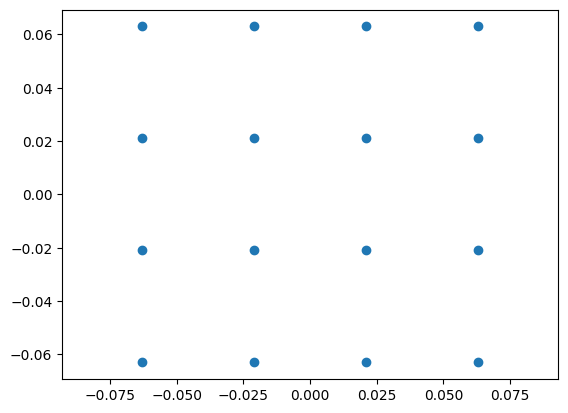

In [35]:
from pathlib import Path

import acoular as ac
import matplotlib.pyplot as plt

micgeofile = Path(ac.__file__).parent / 'xml' / 'minidsp_uma-16_mirrored.xml'
datafile = Path('recorder_output/audio.h5')
assert datafile.exists(), 'Data file not found, run example_three_sources.py first'

mg = ac.MicGeom(file=micgeofile)
ts = ac.TimeSamples(file=datafile)
ps = ac.PowerSpectra(source=ts, block_size=128, window='Hanning')
rg = ac.RectGrid(x_min=-0.2, x_max=0.2, y_min=-0.2, y_max=0.2, z=-0.3, increment=0.01)
st = ac.SteeringVector(grid=rg, mics=mg)
bb = ac.BeamformerBase(freq_data=ps, steer=st)
pm = bb.synthetic(8000, 3)
Lm = ac.L_p(pm)

plt.figure(1)
plt.imshow(Lm.T, origin='lower', vmin=Lm.max() - 10, extent=rg.extend(), interpolation='bicubic')
plt.colorbar()

plt.figure(2)
plt.plot(mg.pos[0], mg.pos[1], 'o')
plt.axis('equal')
plt.show()

In [30]:
from pathlib import Path

import acoular as ac

sfreq = 51200
duration = 1
num_samples = duration * sfreq
micgeofile = Path(ac.__file__).parent / 'xml' / 'minidsp_uma-16.xml'
h5savefile = Path('three_sources8.h5')

m = ac.MicGeom(file=micgeofile)
n1 = ac.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=1)
n2 = ac.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=2, rms=0.7)
n3 = ac.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=3, rms=0.5)
p1 = ac.PointSource(signal=n1, mics=m, loc=(-0.1, -0.1, -0.3))
p2 = ac.PointSource(signal=n2, mics=m, loc=(0.15, 0, -0.3))
p3 = ac.PointSource(signal=n3, mics=m, loc=(0, 0.1, -0.3))
p = ac.Mixer(source=p1, sources=[p2, p3])
wh5 = ac.WriteH5(source=p, file=h5savefile)
wh5.save()